In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
df = pd.read_csv('/content/result.csv', parse_dates=['dt'],)

<Axes: ylabel='dt'>

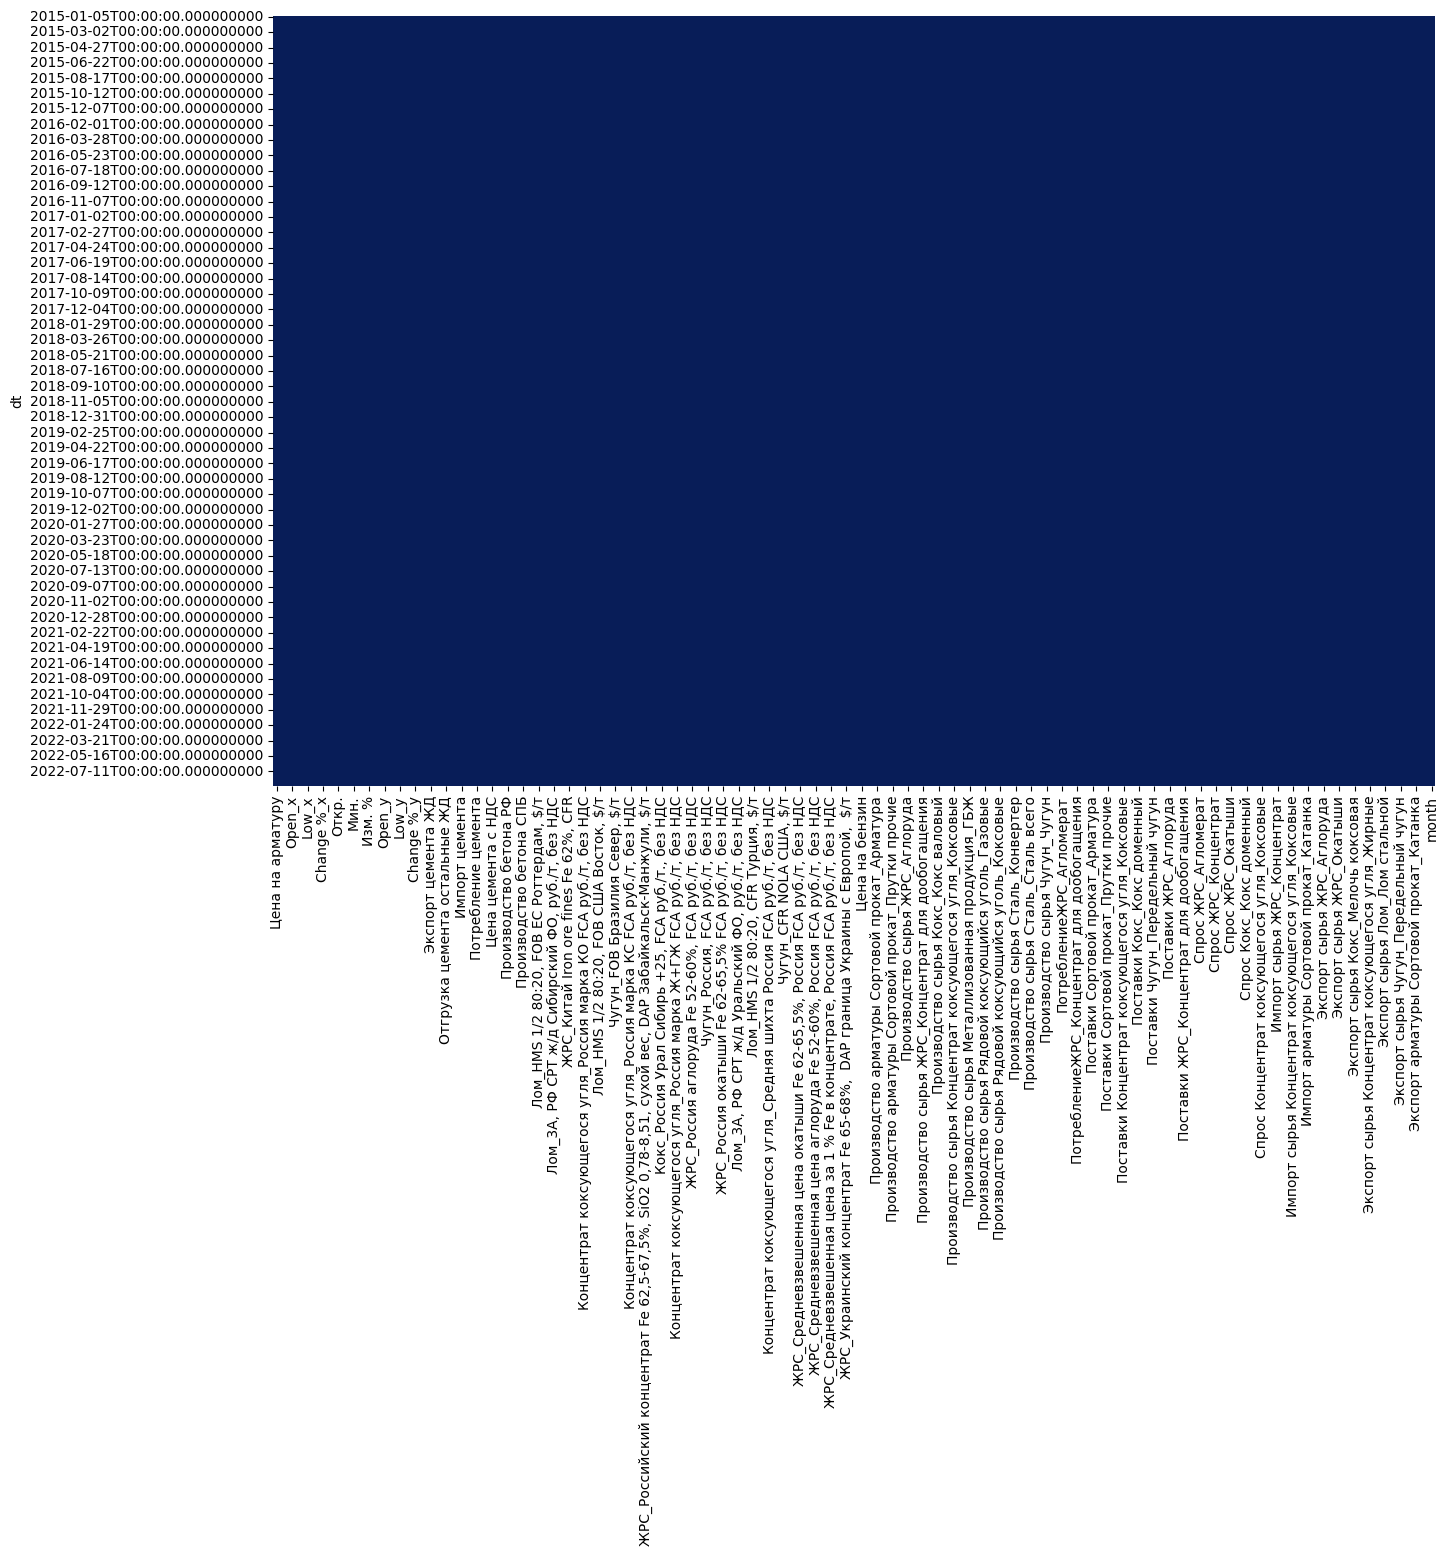

In [ ]:
data = pd.read_csv('/content/result.csv', parse_dates=['dt'], index_col='dt')
plt.figure(figsize = (15,10))
sns.heatmap(data = data.isnull(),cmap="YlGnBu_r",cbar=False)


In [ ]:

!pip install statsmodels==0.14.4

In [ ]:
df['month'].head()

,month
0,2015-01
1,2015-01
2,2015-01
3,2015-01
4,2015-02


In [ ]:
df['dt'] = pd.to_datetime(df['dt'])
df.drop(columns=["month"], inplace=True, errors="ignore")
df['month'] = df['dt'].dt.month
df['month'].head()

,month
0,1
1,1
2,1
3,1
4,2


In [ ]:
print(df['Цена на арматуру'].describe())  # Основные статистики
print(df['Цена на арматуру'].isnull().sum())

count      400.000000
mean     39229.475000
std      13407.979668
min      21000.000000
25%      31075.000000
50%      35450.000000
75%      42000.000000
max      79000.000000
Name: Цена на арматуру, dtype: float64
0


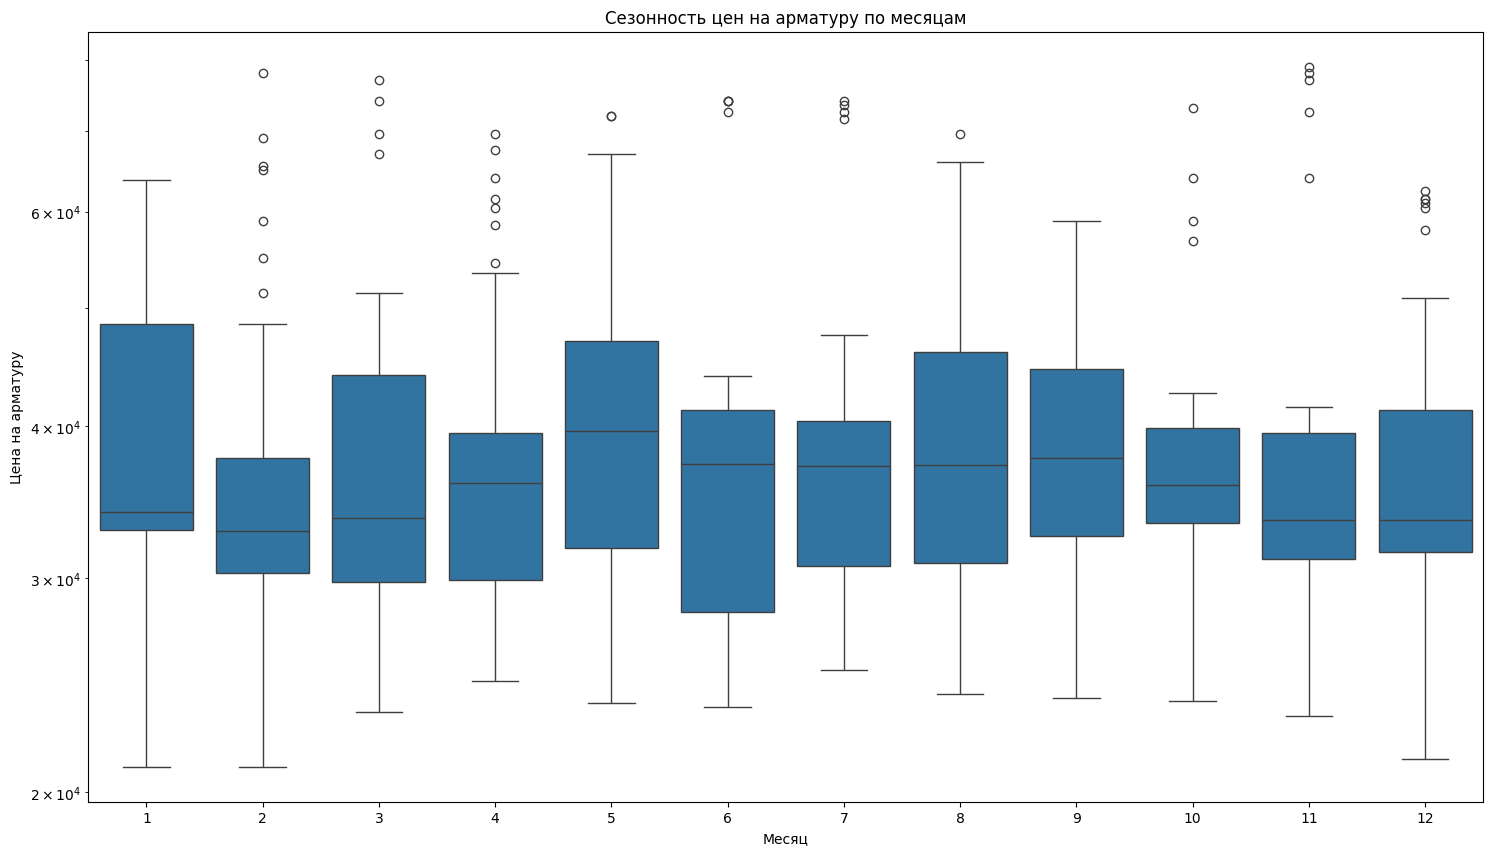

In [ ]:

# Построение boxplot для анализа сезонности по месяцам
plt.figure(figsize=(18, 10))
sns.boxplot(x=df['month'], y=df['Цена на арматуру'])  # Передаем данные напрямую
plt.title('Сезонность цен на арматуру по месяцам')
plt.xlabel('Месяц')
plt.yscale('log')  # Логарифмический масштаб для оси Y
plt.show()

Диапазон цен:

Цены на арматуру варьируются от примерно 20 000 до 60 000 (единицы измерения не указаны, предположительно рубли).

На графике видно, что в некоторые месяцы цены достигают 60 000, а в другие опускаются до 20 000.

Сезонность:

График показывает, что цены на арматуру меняются в зависимости от месяца.

Например, в месяцы 1, 2, 3 (январь, февраль, март) цены находятся в среднем диапазоне.

В месяцы 6, 7, 8 (июнь, июль, август) цены могут быть выше, что может указывать на сезонный спрос.

Выбросы:

На графике видны выбросы (точки за пределами "усов" boxplot), особенно в месяцах 5, 6, 7, 8.

Это может указывать на нестабильность цен в эти периоды или на аномальные значения.

Логарифмический масштаб:

Ось Y (Цена на арматуру) использует логарифмический масштаб, что помогает лучше видеть изменения при большом разбросе значений.

In [ ]:

# Оставляем только числовые данные для анализа
df_numeric = df.select_dtypes(include=["number"])

# Проверяем корреляцию
correlation_matrix = df_numeric.corr()
print(correlation_matrix)


                                                Цена на арматуру   Price_x  \
Цена на арматуру                                        1.000000  0.712148   
Price_x                                                 0.712148  1.000000   
Open_x                                                  0.749590  0.995103   
High_x                                                  0.737547  0.997186   
Low_x                                                   0.723395  0.998380   
...                                                          ...       ...   
Экспорт сырья Чугун_Передельный чугун                   0.659158  0.777963   
Экспорт арматуры Сортовой прокат_Арматура               0.615961  0.723272   
Экспорт арматуры Сортовой прокат_Катанка                0.683340  0.759985   
Экспорт арматуры Сортовой прокат_Прутки прочие         -0.043717 -0.117278   
month                                                  -0.011973 -0.026898   

                                                  Open_x    Hig

In [ ]:
# Шаг 1: Удаление признаков с высокой мультиколлинеарностью
# Оставляем только один из Price_x, Open_x, High_x, Low_x
df = df.drop(columns=['Open_x', 'High_x', 'Low_x'])  # Удаляем все, кроме Price_x

# Шаг 2: Удаление признаков с очень слабой корреляцией
# Вычисляем корреляцию с целевой переменной
corr_with_target = df.corr()['Цена на арматуру'].abs()

# Удаляем признаки с корреляцией < 0.1
weak_features = corr_with_target[corr_with_target < 0.1].index
df = df.drop(columns=weak_features)

# Вывод результата
print("Очищенные данные:")
print(df.head())  # Показываем первые строки очищенного DataFrame

Очищенные данные:
          dt  Цена на арматуру  Price_x    Vol._x  Change %_x    Цена   Откр.  \
0 2015-01-05             32900   1029.8  929280.0        2.82  4470.0  4380.0   
1 2015-01-12             32500   1029.8  929280.0        2.82  4470.0  4380.0   
2 2015-01-19             32000   1029.8  929280.0        2.82  4470.0  4380.0   
3 2015-01-26             30700   1029.8  929280.0        2.82  4470.0  4380.0   
4 2015-02-02             30300   1029.8  929280.0        2.82  4470.0  4380.0   

    Макс.    Мин.         Объём  ...  Экспорт сырья ЖРС_Концентрат  \
0  4480.0  4373.0  1.134000e+09  ...                           5.0   
1  4480.0  4373.0  1.134000e+09  ...                           5.0   
2  4480.0  4373.0  1.134000e+09  ...                           5.0   
3  4480.0  4373.0  1.134000e+09  ...                           5.0   
4  4480.0  4373.0  1.134000e+09  ...                           5.0   

   Экспорт сырья ЖРС_Окатыши  Экспорт сырья Кокс_Мелочь коксовая  \
0     

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series.dropna())  # ADF-тест
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("Ряд стационарный")
    else:
        print("Ряд НЕ стационарный, требуется преобразование")
def check_stationarity(series):
    result = adfuller(series.dropna())  # ADF-тест
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("Ряд стационарный")
    else:
        print("Ряд НЕ стационарный, требуется преобразование")

# Проверяем
check_stationarity(df["Цена на арматуру"])


ADF Statistic: -1.5484468381220473
p-value: 0.5094239275287091
Ряд НЕ стационарный, требуется преобразование


In [ ]:
df["Цена_diff"] = df["Цена на арматуру"].diff()
check_stationarity(df["Цена_diff"].dropna())  # Проверим снова


ADF Statistic: -8.127492209503059
p-value: 1.1130014259295515e-12
Ряд стационарный


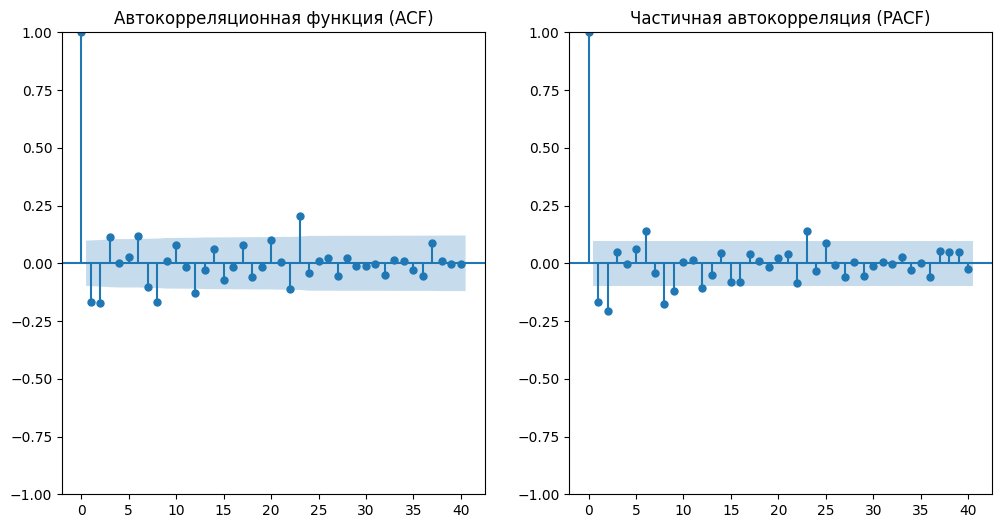

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plot_acf(df["Цена_diff"].dropna(), lags=40, ax=plt.gca())  # ACF
plt.title("Автокорреляционная функция (ACF)")

plt.subplot(1,2,2)
plot_pacf(df["Цена_diff"].dropna(), lags=40, ax=plt.gca())  # PACF
plt.title("Частичная автокорреляция (PACF)")

plt.show()


ACF медленно затухает, что подтверждает нестационарность ряда

PACF имеет значимые лаги на 1 и 2 (возможно AR(2) процесс)

Сезонные пики через регулярные промежутки (например, лаг 12 для месячных данных)


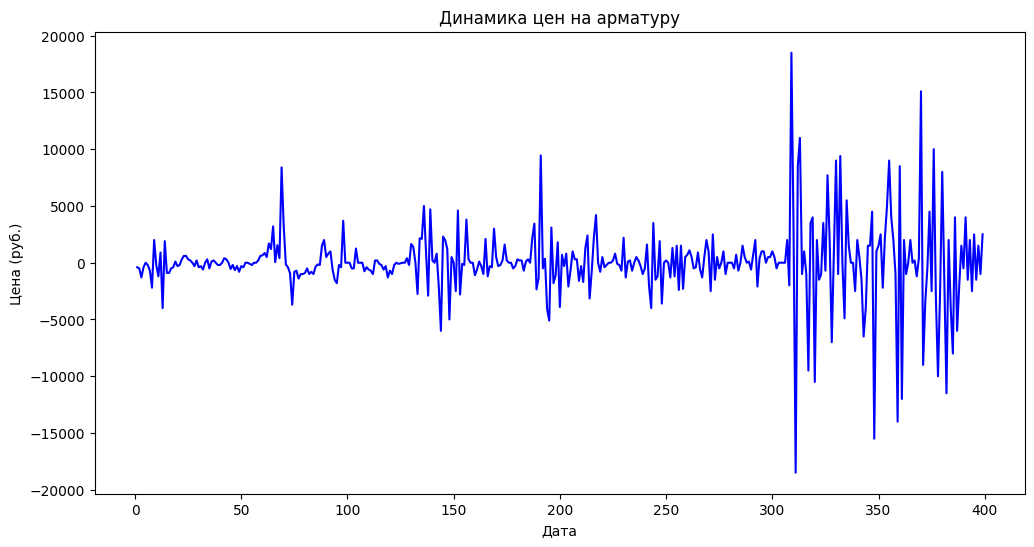

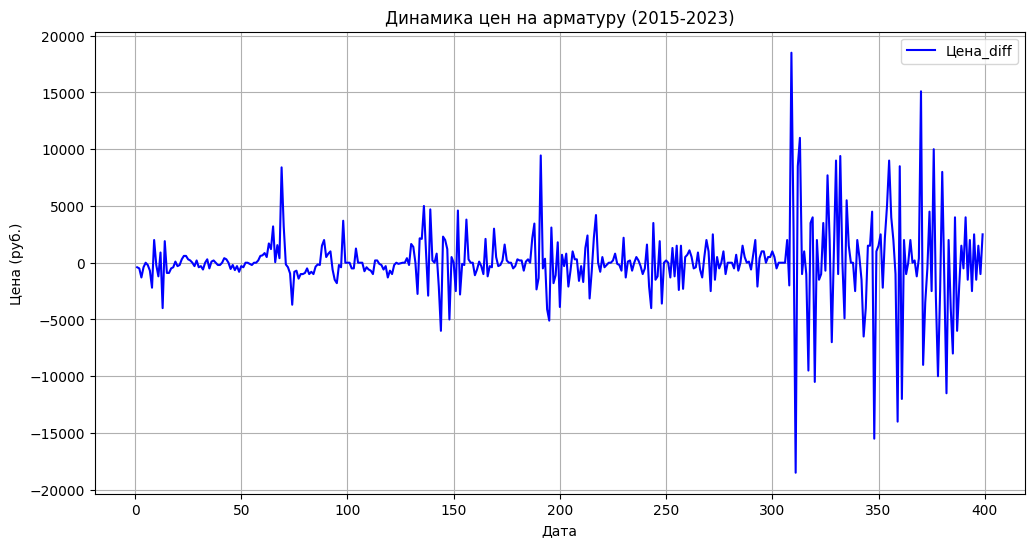

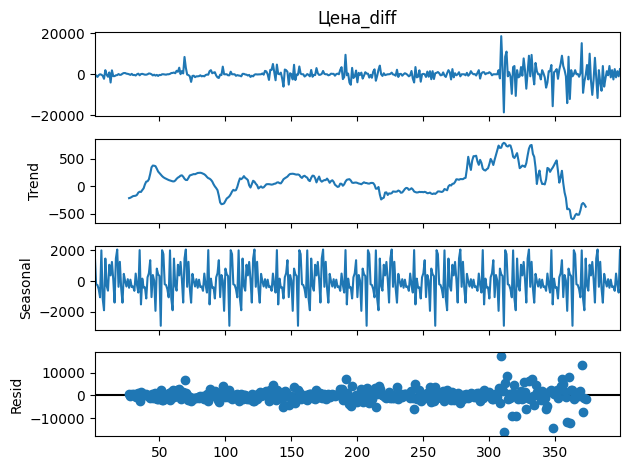

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
df = df.dropna()
# Построение графика динамики цен
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Цена_diff"], label="Цена_diff", color="blue")
plt.xlabel("Дата")
plt.ylabel("Цена (руб.)")
plt.title("Динамика цен на арматуру")

plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Цена_diff"], label="Цена_diff", color="blue")
plt.xlabel("Дата")
plt.ylabel("Цена (руб.)")
plt.title("Динамика цен на арматуру (2015-2023)")
plt.legend()
plt.grid(True)
plt.show()

# Разложение временного ряда на тренд, сезонность и остатки
decomposition = seasonal_decompose(df["Цена_diff"], period=52, model="additive")
decomposition.plot()
plt.show()


Основной временной ряд (верхняя панель) демонстрирует общий рост цен с 2015 по 2022 год, с резкими скачками начиная с 2020 года.

Трендовая составляющая подтверждает общий восходящий тренд с ослаблением роста в 2022 году.

Сезонная компонента показывает выраженную периодичность, предположительно годовую.

Остаточная компонента демонстрирует увеличенную волатильность после 2020 года, что может указывать на внешние рыночные шоки или нестабильность.
Колебания становятся более выраженными начиная примерно с 2020 года, что подтверждает возросшую волатильность.

Периоды высокой амплитуды могут совпадать с ключевыми экономическими событиями.

Резкие всплески вверх и вниз свидетельствуют о краткосрочных ценовых шоках, которые могут быть вызваны изменениями спроса, предложения или внешними факторами.

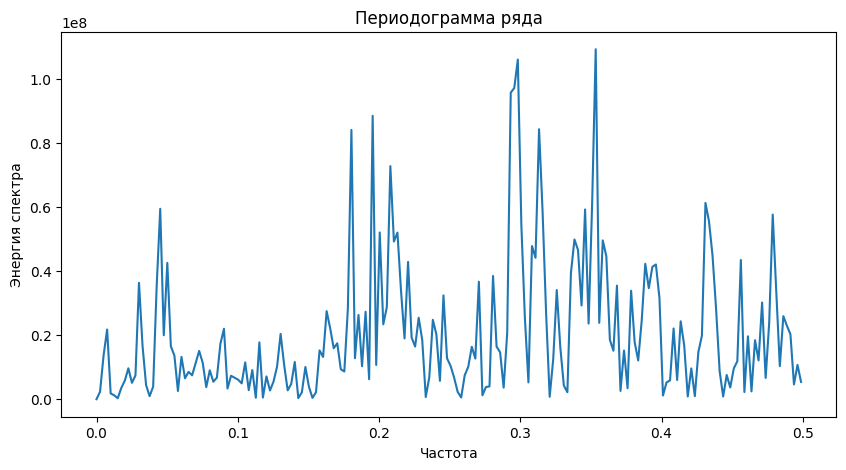

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram

# Предположим, что у вас есть временной ряд 'Цена_diff'
f, Pxx = periodogram(df['Цена_diff'].dropna())

plt.figure(figsize=(10, 5))
plt.plot(f, Pxx)
plt.xlabel("Частота")
plt.ylabel("Энергия спектра")
plt.title("Периодограмма ряда")
plt.show()


Анализ частотного спектра временного ряда показывает наличие выраженных частотных пиков, что свидетельствует о наличии сезонных или циклических составляющих в данных.

Значительные пики на низких частотах могут указывать на долгосрочные тренды.

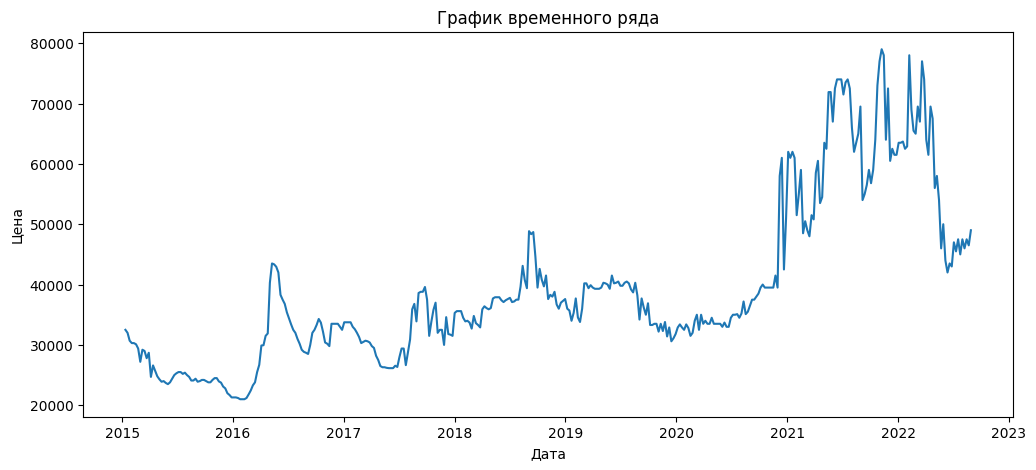

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df["dt"], df["Цена на арматуру"])
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("График временного ряда")
plt.show()


Наблюдается нестационарность ряда с выраженным трендом (долгосрочный рост цен)

Присутствуют сезонные колебания (периодические всплески и спады)

Возможны структурные изменения (резкие скачки, возможно связанные с внешними факторами)

In [ ]:
!pip install xgboost


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

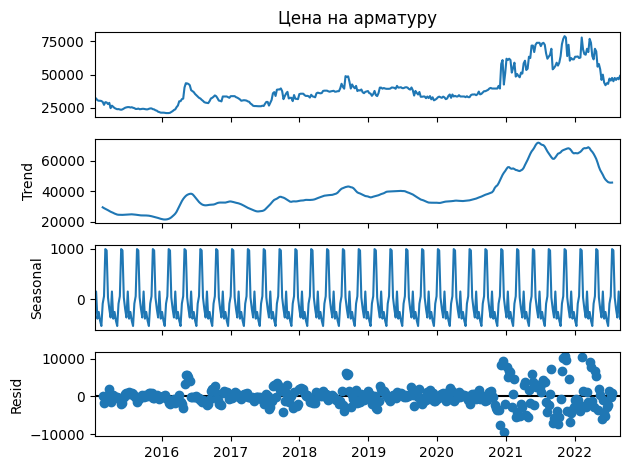

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Лучшие параметры:  {'model__max_depth': None, 'model__max_features': 0.5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 300}
MAE: 4688.16
RMSE: 6073.10
MAE базовой модели (persistence): 4065.52


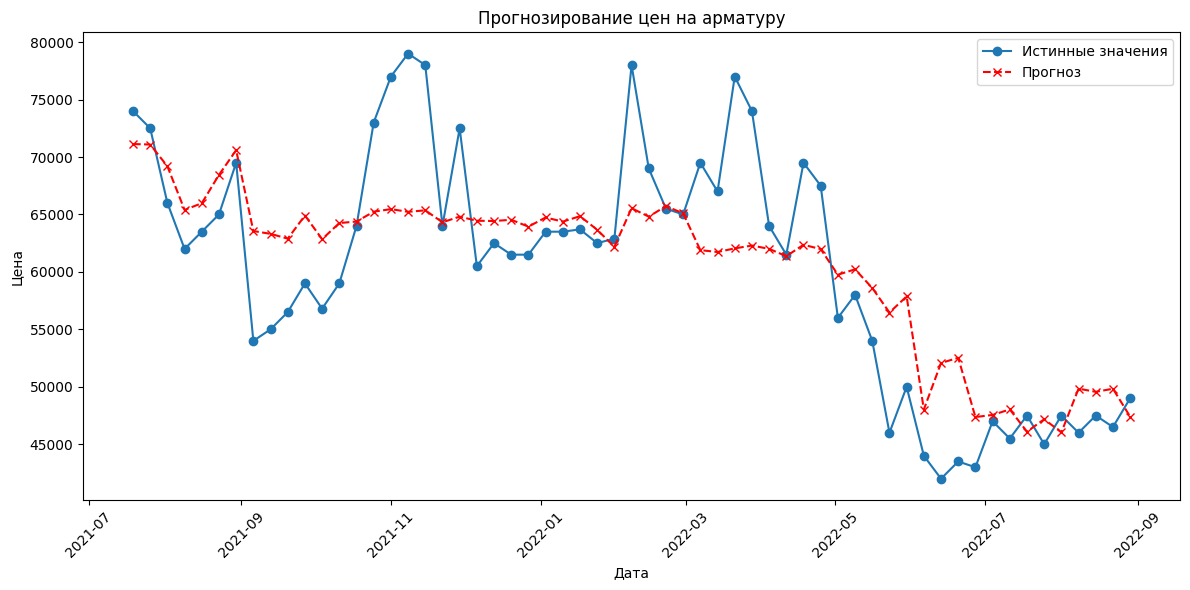

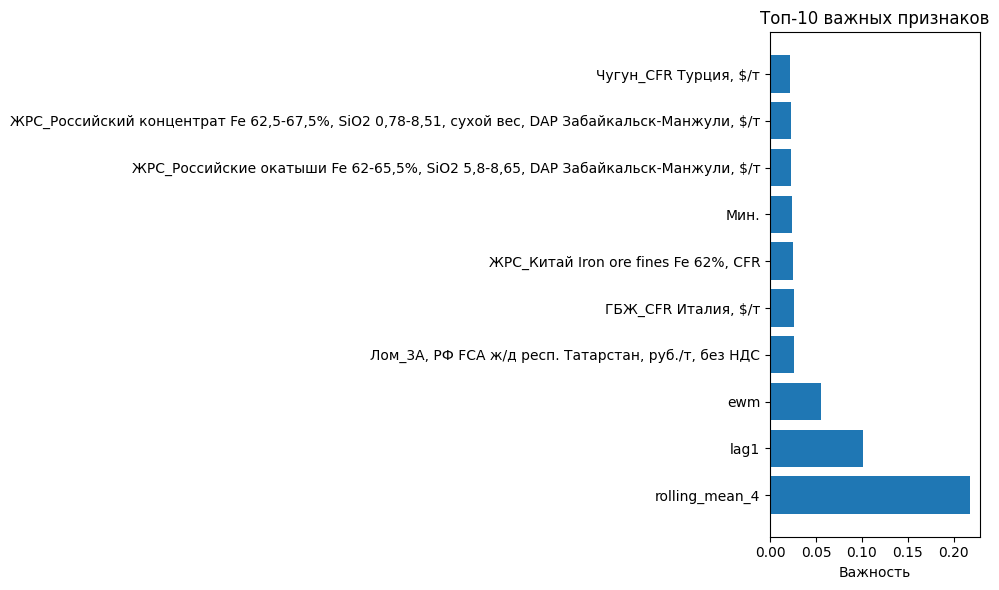

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Загрузка данных (замените на ваш путь)
# df = pd.read_csv('your_data.csv')
df['dt'] = pd.to_datetime(df['dt'])  # Преобразуем столбец с датой в datetime
df = df.sort_values(by='dt').set_index('dt')

# 1. Анализ временного ряда
decomposition = seasonal_decompose(df['Цена на арматуру'], period=12)
decomposition.plot()
plt.show()

# 2. Создание расширенных временных признаков
def create_features(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['week'] = df.index.isocalendar().week
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    df['lag1'] = df['Цена на арматуру'].shift(1)
    df['lag4'] = df['Цена на арматуру'].shift(4)
    df['lag8'] = df['Цена на арматуру'].shift(8)
    df['rolling_mean_4'] = df['Цена на арматуру'].rolling(window=4).mean()
    df['rolling_std_4'] = df['Цена на арматуру'].rolling(window=4).std()
    df['rolling_mean_12'] = df['Цена на арматуру'].rolling(window=12).mean()
    df['ewm'] = df['Цена на арматуру'].ewm(span=12, adjust=False).mean()
    return df

df = create_features(df)
df = df.dropna()

# 3. Разделение данных с учетом временного ряда
target = 'Цена на арматуру'
features = [col for col in df.columns if col != target]

# Используем TimeSeriesSplit для кросс-валидации
train_size = int(len(df) * 0.85)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

# 4. Создание конвейера с масштабированием и моделью
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# 5. Улучшенная сетка параметров
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', 0.5]
}

# 6. Используем TimeSeriesSplit для кросс-валидации
tscv = TimeSeriesSplit(n_splits=5)

# 7. Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    scoring='neg_mean_absolute_error'
)

# 8. Обучение модели
grid_search.fit(X_train, y_train)

# 9. Оценка модели
best_model = grid_search.best_estimator_
print("Лучшие параметры: ", grid_search.best_params_)

# Прогнозирование
y_pred = best_model.predict(X_test)

# Метрики
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

# 10. Сравнение с базовой моделью
baseline_pred = np.roll(y_test, 1)  # Простое предсказание "завтра как сегодня"
baseline_mae = mean_absolute_error(y_test[1:], baseline_pred[1:])
print(f'MAE базовой модели (persistence): {baseline_mae:.2f}')

# 11. Визуализация
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, y_test, label='Истинные значения', marker='o')
plt.plot(test_df.index, y_pred, label='Прогноз', linestyle='--', marker='x', color='red')
plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 12. Анализ важности признаков
if hasattr(best_model.named_steps['model'], 'feature_importances_'):
    feature_importances = pd.DataFrame({
        'feature': features,
        'importance': best_model.named_steps['model'].feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances['feature'][:10], feature_importances['importance'][:10])
    plt.title('Топ-10 важных признаков')
    plt.xlabel('Важность')
    plt.tight_layout()
    plt.show()